In [1]:
%matplotlib inline
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=16)
import numpy as np
import warnings
import csv
from collections import OrderedDict


from hyperfet.devices import SCMOSFET
from hyperfet.references import si

from functools import reduce
from operator import add
from scipy.optimize import curve_fit
from hyperfet.fitting import show_transistor, curve_fit_scaled, display_table

# Import simulations from cadence

In [2]:
W=si("2*23nm+10nm")
VDD=.8
prefix='ptm_14nm_lstp_'
ptm=OrderedDict()
for fname in ['idvg','idvd_p45','idvd_p54','idvd_p63','idvd_p72','idvd_p8']:
    with open(prefix+fname+'.csv') as f:
        next(f)
        data=ptm[fname.replace('p','.')]={}
        data['v'],data['i']=np.hsplit(np.array([[float(x) for x in l.split(',')] for l in f]),2)
        data['i/W']=data['i']/W

# Super rough fit by hand

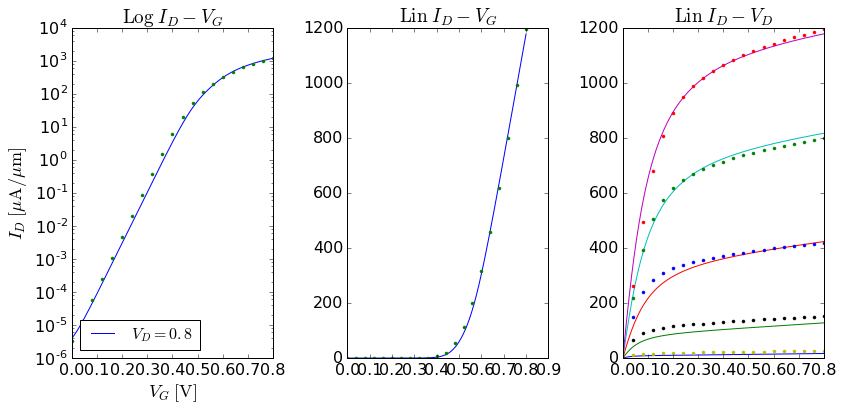

In [3]:
opts={
    'figsize': (12,6),
    'subplots': True
}
fet_by_hand=None
p0=None
@interact(VT0=FloatSlider(value=.56,min=0,max=1,step=.05,continuous_update=False),
          Cinv_vxo=FloatSlider(value=4700,min=1000,max=5500,step=400,continuous_update=False),
          SS=FloatSlider(value=.065,min=.05,max=.09,step=.005,continuous_update=False),
          alpha=FloatSlider(value=1.5,min=0,max=5,step=.5,continuous_update=False),
          beta=FloatSlider(value=1.5,min=0,max=4,step=.1,continuous_update=False),
          VDsats=FloatSlider(value=.12,min=.1,max=2,step=.1,continuous_update=False),
          delta=FloatSlider(value=.025,min=0,max=.5,step=.1,continuous_update=False),
          log10Gleak=FloatSlider(value=-13,min=-14,max=-5,step=1,continuous_update=False)
         )
def show_HEMT(VT0,Cinv_vxo,SS,alpha,beta,VDsats,delta,log10Gleak):
    global fet_by_hand, p0
    fet=SCMOSFET(
        W=W,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    p0=[VT0,Cinv_vxo,SS,alpha,beta,VDsats,delta,log10Gleak]
    show_transistor(fet,VDD,data=ptm,**opts)
    
    fet_by_hand=fet

# Automatic fit refinement

Note that all IDVG currents are in returned as the logarithm, and all IDVD currents are returned as divided by $(100*W)$.  This scaling helps make sure both IDVG and IDVD are reasonably fit.  The Cinv_vxo parameter is scaled down by 1000 in the parameter array to be of the same order as the other parameters

In [4]:
idvd_ratio=1/(100*W)
def rescale_idvg(I,idvg_marker):
    I[idvg_marker]=np.log(I[idvg_marker])
    I[~idvg_marker]=I[~idvg_marker]*idvd_ratio
    return I

In [5]:
idvg_marker=np.array([True]*len(ptm['idvg']['v'])\
    +[False]*sum(len(ptm[fname]['v']) for fname in ptm.keys() if fname.startswith('idvd')))
VD=[VDD]*len(ptm['idvg']['v'])+reduce(add,(list(np.ravel(ptm[fname]['v']))
            for fname in ptm.keys() if fname.startswith("idvd")))
VG=list(ptm['idvg']['v'])+reduce(add,([float(fname.split("_")[1])]*len(ptm[fname]['v'])
            for fname in ptm.keys() if fname.startswith("idvd")))
V=np.hstack([VD,VG])
I=np.array(list(np.ravel(ptm['idvg']['i']))+\
    reduce(add,[list(np.ravel(ptm[fname]['i'])) for fname in ptm.keys() if fname.startswith("idvd")]))
rescale_idvg(I,idvg_marker);

def IVfunc(V,*p):
    VT0,Cinv_vxo,SS,alpha,beta,VDsats,delta,log10Gleak=p

    fet=SCMOSFET(
        W=W,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    VD,VG=np.hsplit(V,2)
    return rescale_idvg(fet.ID(VD,VG),idvg_marker)


bounds=list(zip(*[(0,1),(3000,6000),(.06,.1),(0,5),(.5,3),(.05,.5),(0,.1),(-14,-12)]))
scalings=[1,1000,1,1,1,1,1,1]
pp=curve_fit_scaled(IVfunc,V,I,p0=p0,bounds=bounds,param_scalings=scalings)[0]

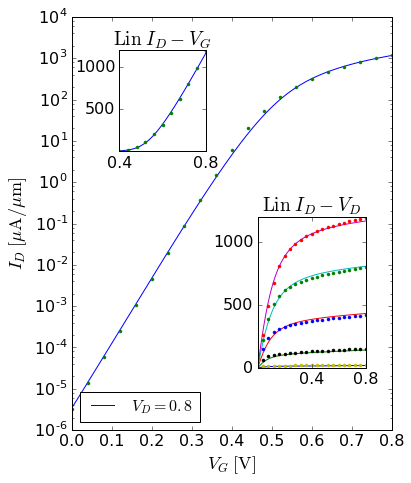

In [10]:
fet_by_fit=None
opts={
    'figsize': (6,7),
    'linidvgpos': [.3,.68,.2,.2],
    'linidvgxticks': [.4,.8],
    'linidvgxlim': [.4,.8],
    'linidvgyticks': [500,1000],
    'linidvdpos': [.62,.25,.25,.3],
    'linidvdxticks': [.4,.8],
    'linidvdyticks': [0,500,1000],
}
def show_fitted_HEMT(VT0,Cinv_vxo,SS,alpha,beta,VDsats,delta,log10Gleak):
    global fet_by_fit
    fet=SCMOSFET(
        W=W,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    show_transistor(fet,VDD,data=ptm,**opts)
    fet_by_fit=fet
show_fitted_HEMT(*pp)

In [8]:
display_table(OrderedDict(zip(['VT0','Cinv_vxo','SS','alpha','beta','VDsats','delta','log10Gleak'],pp)))

VT0,Cinv_vxo,SS,alpha,beta,VDsats,delta,log10Gleak
0.5669,4832,0.06282,2.923,1.711,0.1475,0.01748,-13.93
